In [8]:
import psycopg2
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
load_dotenv()


# Connection details
host = "localhost"
port = "5432"
database = "postgres"
username = os.environ.get('USER')
password = os.environ.get('PASSWORD')

# Insert Excel data into Postgresql database

In [41]:
customers = pd.read_excel('./data/customer_order_product.xlsx', sheet_name='Sheet1')
customers

,customer_id,name,email,address
0,1,John Doe,john@example.com,123 Main St
1,2,Jane Smith,jane@example.com,456 Elm St
2,3,Mike Johnson,mike@example.com,789 Oak St


In [43]:
# Connect to the PostgreSQL database
db_url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(db_url)

for i, table in enumerate(['customers', 'orders', 'products']):
    df = pd.read_excel(f'./data/customer_order_product.xlsx', sheet_name=f'Sheet{i+1}')
    df.to_sql(table, engine, if_exists='replace', index=False)

engine.dispose()

# Small data analysis with Pandas

In [24]:
# Connect to the PostgreSQL database
connection = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=username,
    password=password
)

# Create a cursor object to interact with the database
cursor = connection.cursor()

# Execute SQL queries
cursor.execute("""
    SELECT c.name AS customer_name, o.quantity AS quantity, p.name AS product_name
    FROM orders o 
    JOIN customers c
        ON o.customer_id = c.customer_id
    JOIN products p
        ON o.product_id = p.product_id
""")

customer_order_product_small = cursor.fetchall()

# Create pandas dataframe for analysis
customer_order_product_small = pd.DataFrame(data=customer_order_product_small, columns=['customer_name', 'quantity', 'product_name'])

# Close the cursor and connection
cursor.close()
connection.close()

In [25]:
customer_order_product_small

,customer_name,quantity,product_name
0,John Doe,2,T-shirt
1,Mike Johnson,1,T-shirt
2,Jane Smith,2,Jeans
3,John Doe,1,Sneakers


### Find best customer

In [26]:
customer_purchase_quantity = customer_order_product_small.groupby(by='customer_name')['quantity'].sum().reset_index()
customer_purchase_quantity

,customer_name,quantity
0,Jane Smith,2
1,John Doe,3
2,Mike Johnson,1


In [27]:
customer_purchase_quantity_sorted = customer_purchase_quantity.sort_values(by='quantity', ascending=False)
customer_purchase_quantity_sorted

,customer_name,quantity
1,John Doe,3
0,Jane Smith,2
2,Mike Johnson,1


<AxesSubplot:xlabel='customer_name', ylabel='quantity'>

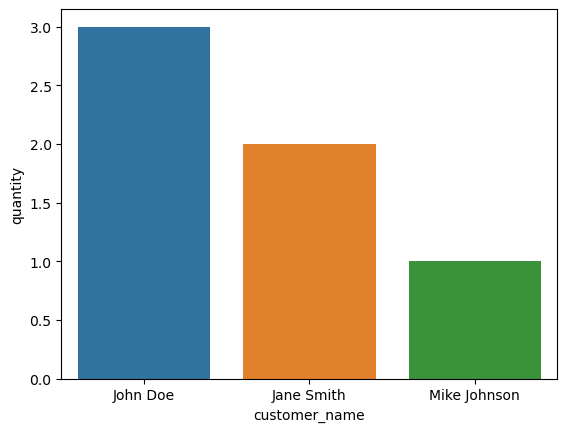

In [28]:
sns.barplot(data=customer_purchase_quantity_sorted, x='customer_name', y='quantity')

### Find best product

In [29]:
product_purchase_quantity = customer_order_product_small.groupby(by='product_name')['quantity'].sum().reset_index()
product_purchase_quantity

,product_name,quantity
0,Jeans,2
1,Sneakers,1
2,T-shirt,3


In [30]:
product_purchase_quantity_sorted = product_purchase_quantity.sort_values(by='quantity', ascending=False)
product_purchase_quantity_sorted

,product_name,quantity
2,T-shirt,3
0,Jeans,2
1,Sneakers,1


<AxesSubplot:xlabel='product_name', ylabel='quantity'>

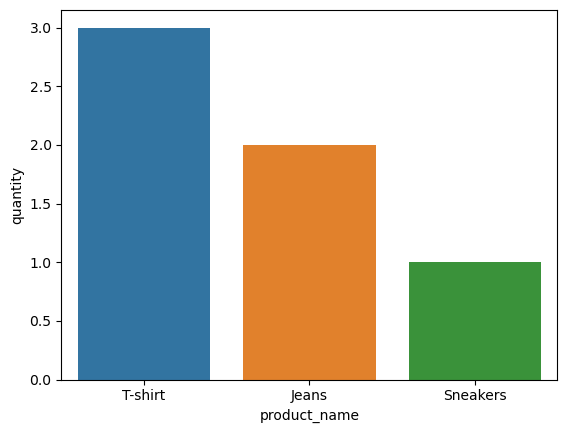

In [31]:
sns.barplot(data=product_purchase_quantity_sorted, x='product_name', y='quantity')

# Big Data analysis with Spark

In [32]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Read from PostgreSQL") \
    .config("spark.jars", "/Users/nhamhhung/Teaching/week1/postgresql-42.6.0.jar") \
    .config("spark.driver.extraClassPath", "/Users/nhamhhung/Teaching/week1/postgresql-42.6.0.jar") \
    .getOrCreate()

23/05/29 19:02:21 WARN Utils: Your hostname, Nhams-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.134 instead (on interface en0)
23/05/29 19:02:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/05/29 19:02:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [33]:
for table_name in ['customers', 'orders', 'products']:
    big_table_df = spark.read \
        .format("jdbc") \
        .option("driver", "org.postgresql.Driver") \
        .option("url", "jdbc:postgresql://localhost:5432/postgres") \
        .option("dbtable", table_name) \
        .option("user", os.environ.get("USER")) \
        .option("password", os.environ.get("PASSWORD")) \
        .load()
    
    big_table_df.createOrReplaceTempView(table_name)

In [34]:
customer_order_product_big = spark.sql("""
    SELECT c.name AS customer_name, o.quantity AS quantity, p.name AS product_name
    FROM orders o 
    JOIN customers c
        ON o.customer_id = c.customer_id
    JOIN products p
        ON o.product_id = p.product_id
""")

customer_order_product_big.createOrReplaceTempView('customer_order_product_big')
customer_order_product_big.show()

+-------------+--------+------------+
|customer_name|quantity|product_name|
+-------------+--------+------------+
| Mike Johnson|       1|     T-shirt|
|     John Doe|       2|     T-shirt|
|     John Doe|       1|    Sneakers|
|   Jane Smith|       2|       Jeans|
+-------------+--------+------------+



### Find best customer

In [35]:
best_customer = spark.sql("""
    SELECT customer_name, SUM(quantity) AS quantity
    FROM customer_order_product_big
    GROUP BY customer_name
    ORDER BY quantity DESC
""")

best_customer.show()

+-------------+--------+
|customer_name|quantity|
+-------------+--------+
|     John Doe|       3|
|   Jane Smith|       2|
| Mike Johnson|       1|
+-------------+--------+



In [36]:
customer_purchase_quantity = best_customer.toPandas()
customer_purchase_quantity

,customer_name,quantity
0,John Doe,3
1,Jane Smith,2
2,Mike Johnson,1


<AxesSubplot:xlabel='customer_name', ylabel='quantity'>

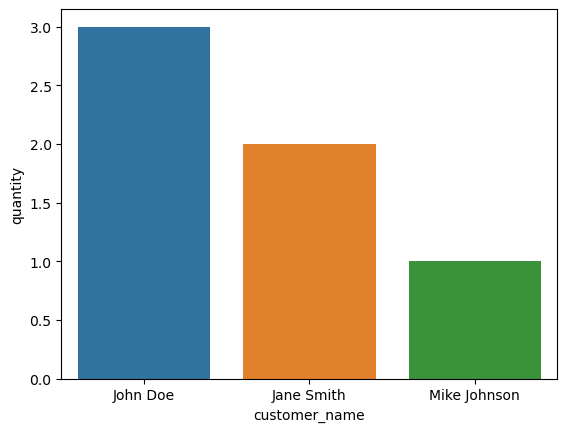

In [37]:
sns.barplot(data=customer_purchase_quantity, x='customer_name', y='quantity')

### Find best product

In [38]:
best_product = spark.sql("""
    SELECT product_name, SUM(quantity) AS quantity
    FROM customer_order_product_big
    GROUP BY product_name
    ORDER BY quantity DESC
""")

best_product.show()

+------------+--------+
|product_name|quantity|
+------------+--------+
|     T-shirt|       3|
|       Jeans|       2|
|    Sneakers|       1|
+------------+--------+



In [39]:
product_purchase_quantity = best_product.toPandas()
product_purchase_quantity

,product_name,quantity
0,T-shirt,3
1,Jeans,2
2,Sneakers,1


<AxesSubplot:xlabel='product_name', ylabel='quantity'>

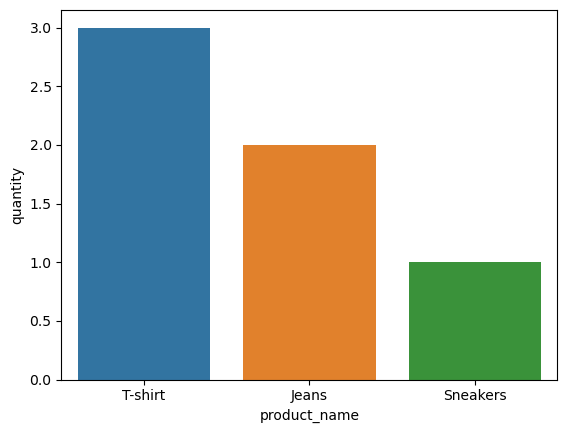

In [40]:
sns.barplot(data=product_purchase_quantity, x='product_name', y='quantity')